In [1]:
import os
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import permutations
from multistate_extrusion_networks.CyclicCohesinNetwork import CyclicCohesinNetwork

The following notebook includes code to:
- i. Generate a combinatorial set of networks.
- ii. Use experimental biophysical measurements to parameterize networks.
- iii. Prune networks to arrive at a single reaction network consistent with available data. 

Finally, this notebook includes code for simulating depletions and generating configuration files for lattice and polymer simulations.

# Five state models

## Combinatorial network generation


We use the following notation for chemical species:

- "RB": 'bare' bound cohesin, "R" free cohesin
- "RN":  bound cohesin co-bound with NIPBL, "N" free NIPBL
- "RP":  bound cohesin co-bound with PDS5, "P" free PDS5
- "RW":  bound cohesin co-bound with WAPL, "W" free WAPL

This enables convenient enumeration of possible chemical reaction pathways, as illustrated below in the case in the case of cyclic networks. 

In [2]:
bound_states = ['RB', 'RN', 'RP', 'RW']
sequence_list = list(permutations(bound_states))

network_list = []

for sequence in sequence_list:
    network = CyclicCohesinNetwork(sequence)
    network_list.append(network)

## Parameter inference

In [3]:
biophys_df = pd.read_csv('../data/biophysical_params_HeLa.csv', comment='#')

parameter_dict_wt = dict(zip(biophys_df['parameter'].values, biophys_df['value'].values))

Curated biophysical measurements include the residence time, bound fraction, and abundance of each of RAD21, NIPBL, PDS5, and WAPL.

Since transition rates between states are not directly determined experimentally, the following code inverts the set of equations using the known measurements to determine transition rates (as well as prune unphysical networks with negative rates, which are not compatible with the input experimental constraints). 

In [4]:
verbose = True
physical_networks = []

for network in network_list:
    network.solve_rates(parameter_dict_wt)
    has_physical_kinetics = all(value > 0 for value in network.rate_dict.values())

    if has_physical_kinetics:
        physical_networks.append(network)

        if verbose:
            print(f"{network.sequence}: OK")

    else:
        if verbose:
            print(f"{network.sequence}: {', '.join(k+' < 0' for k, v in network.rate_dict.items() if v < 0)}")

('RB', 'RN', 'RP', 'RW'): k_NB < 0
('RB', 'RN', 'RW', 'RP'): k_NW < 0, k_WN < 0
('RB', 'RP', 'RN', 'RW'): OK
('RB', 'RP', 'RW', 'RN'): k_WP < 0
('RB', 'RW', 'RN', 'RP'): k_NW < 0, k_WN < 0
('RB', 'RW', 'RP', 'RN'): k_WB < 0
('RN', 'RB', 'RP', 'RW'): OK
('RN', 'RB', 'RW', 'RP'): k_BW < 0, k_WB < 0
('RN', 'RP', 'RB', 'RW'): OK
('RN', 'RP', 'RW', 'RB'): k_BW < 0
('RN', 'RW', 'RB', 'RP'): k_BW < 0
('RN', 'RW', 'RP', 'RB'): k_PW < 0
('RP', 'RB', 'RN', 'RW'): OK
('RP', 'RB', 'RW', 'RN'): k_WB < 0
('RP', 'RN', 'RB', 'RW'): k_BN < 0, k_NB < 0
('RP', 'RN', 'RW', 'RB'): k_NW < 0, k_WN < 0
('RP', 'RW', 'RB', 'RN'): k_BW < 0, k_WB < 0
('RP', 'RW', 'RN', 'RB'): k_NW < 0, k_WN < 0
('RW', 'RB', 'RN', 'RP'): k_BN < 0, k_NB < 0
('RW', 'RB', 'RP', 'RN'): OK
('RW', 'RN', 'RB', 'RP'): OK
('RW', 'RN', 'RP', 'RB'): OK
('RW', 'RP', 'RB', 'RN'): OK
('RW', 'RP', 'RN', 'RB'): k_BN < 0


To further constrain the space of possible models, we also exploit experimental measurements of loaded cohesin fraction in various mutant cell lines.

In [5]:
# pertubation = [perturb_param, perturb_ratio, conditions={species:relative_bound_ratio}]
perturbations = [
    ['N_W', 1/5, {'R':'>1'}], #F_R goes up in dWAPL: Wutz2017 Fig4F 
    ['N_P', 1/5, {'R':'>1'}], #F_R goes up in dPDS5: Wutz2017 Fig4F
    ['N_N', 1/5, {'R':'<1'}], #F_R goes down in dNIPBL: Haarhuis2017 Fig4E
]


Compute loaded RAD21 amount relative to WT upon perturbation of a regulator (as described by a new parameter dictionary)

In [6]:
def get_relative_bound(network, parameter_dict, species, time=10000):
    if not species in network.abundances.keys():        
        print(f"Species {species} not in known state symbols")

    else:
        abundance = str(network.abundances[species])
        bound_fraction = str(network.bound_fractions[species])

        kinetics = network.solve_kinetics(parameter_dict, t_max=time)
        final_state = kinetics.y[:,-1]

        wt_bound = network.parameter_dict_wt[abundance] * network.parameter_dict_wt[bound_fraction]
        final_bound = parameter_dict[abundance] - final_state[network.state_ids[species]]

        return final_bound / wt_bound

Enumerate all models satisfying experimental constraints

In [7]:
candidate_networks = []

for network in physical_networks:
    check_list = []

    for perturbation in perturbations:
        perturbation_param, perturbation_ratio, consequences = perturbation
            
        parameter_dict_mut = parameter_dict_wt.copy()
        parameter_dict_mut[perturbation_param] *= perturbation_ratio

        for species, value in consequences.items():
            ratio = get_relative_bound(network, parameter_dict_mut, species)                
            check_list.append(eval(f"{ratio}{value}"))
        
    if verbose: 
        print(network.sequence)
        print(", ".join(f"{p[0]}: {c}" for p, c in zip(perturbations, check_list)))

    if np.array(check_list).all():            
        candidate_networks.append(network)

('RB', 'RP', 'RN', 'RW')
N_W: True, N_P: True, N_N: False
('RN', 'RB', 'RP', 'RW')
N_W: True, N_P: True, N_N: True
('RN', 'RP', 'RB', 'RW')
N_W: True, N_P: False, N_N: True
('RP', 'RB', 'RN', 'RW')
N_W: True, N_P: False, N_N: False
('RW', 'RB', 'RP', 'RN')
N_W: False, N_P: True, N_N: False
('RW', 'RN', 'RB', 'RP')
N_W: False, N_P: True, N_N: True
('RW', 'RN', 'RP', 'RB')
N_W: False, N_P: False, N_N: True
('RW', 'RP', 'RB', 'RN')
N_W: False, N_P: False, N_N: False


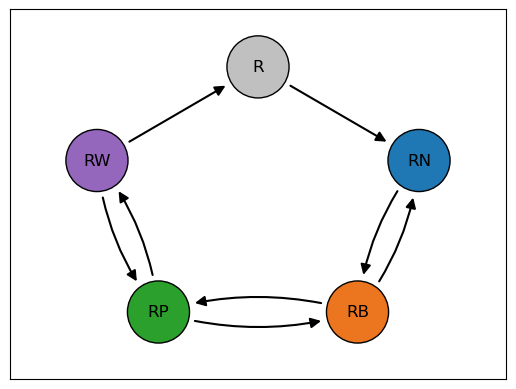

In [8]:
color_dict={'R':'#C0C0C0', 'RB':'#EC761F', 'RN':'#1F77B4', 'RP':'#2CA02C', 'RW':'#9467BD'}

for network in candidate_networks:
    network.draw(color_dict)

## Time integration
Let us designate the one remaining candidate as the "five-state network"

In [9]:
five_state_network = candidate_networks[0]
sequence_string = "_".join(five_state_network.sequence)

five_state_names = five_state_network.full_states[:5]
five_state_colors = [*map(color_dict.get, five_state_names)]

Compute model population kinetics by solving the corresponding coupled ODE's

In [10]:
kinetics = five_state_network.solve_kinetics(parameter_dict_wt)
time, solution = kinetics.t, kinetics.y

Plot resulting equilibration dynamics, starting from a fully-unloaded RAD21 population

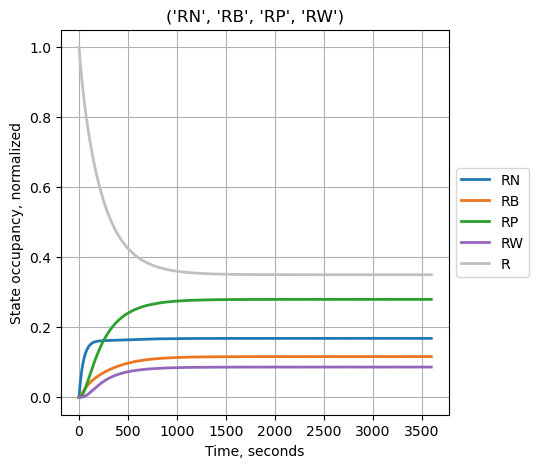

In [11]:
figwidth = 5
save_trajectory = True

plt.figure(figsize=(figwidth, figwidth)) 

plt.gca().set_prop_cycle(color=five_state_colors)

plt.plot(time, solution[:5].T / parameter_dict_wt['N_R'], lw=2,) 
plt.legend(five_state_names, shadow=False, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(five_state_network.sequence)
plt.grid(True)

_ = plt.xlabel('Time, seconds')
_ = plt.ylabel('State occupancy, normalized')

if save_trajectory:
    output_kin_path = f"../data/state_kinetics_HeLa_{sequence_string}.res"
    ordered_solution = np.roll(solution[:5], 1, axis=0)
    
    np.savetxt(output_kin_path, np.r_[time[None,:], ordered_solution].T)

Let us now simulate WAPL depletion by reducing the number of WAPL by 5-fold

In [12]:
parameter_dict_dWAPL = parameter_dict_wt.copy()
parameter_dict_dWAPL['N_W'] /= 5

kinetics_dWAPL = five_state_network.solve_kinetics(parameter_dict_dWAPL)
time_dWAPL, solution_dWAPL = kinetics_dWAPL.t, kinetics_dWAPL.y

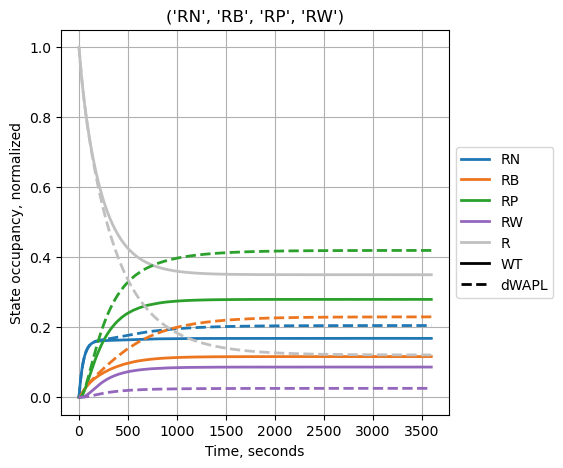

In [13]:
plt.figure(figsize=(figwidth, figwidth)) 

plt.gca().set_prop_cycle(color=five_state_colors)

plt.plot(time, solution[:5].T / parameter_dict_wt['N_R'], lw=2) 

plt.plot([], [], 'k', lw=2) 
plt.plot([], [], 'k--', lw=2) 

plt.plot(time_dWAPL, solution_dWAPL[:5].T / parameter_dict_dWAPL['N_R'], ls='--', lw=2) 
plt.legend(five_state_names+['WT', 'dWAPL'], shadow=False, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(five_state_network.sequence)
plt.grid(True)

_ = plt.xlabel('Time, seconds')
_ = plt.ylabel('State occupancy, normalized')

## Dictionary generation for lattice simulations
For stochastic lattice-based simulations of loop extrusion, as well as coupling the model with 3D polymer simulations, it is convenient to convert chemical network parameters into more concise dictionary files.

In [14]:
extrusion_dict_wt = five_state_network.to_extrusion_dict(parameter_dict_wt)
dict_path = f"../data/extrusion_dict_HeLa_{sequence_string}.json"

with open(dict_path, 'w') as dict_file:
    json.dump(extrusion_dict_wt, dict_file, indent=4)

For parameter sweeps, mutant dictionaries can also be easily generated across multiple depletion levels as shown below

In [15]:
parameter = 'N_W'
depletion_levels = np.linspace(0.1, 1, num=10)

out_dir = f"../data/{parameter}"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
for level in depletion_levels:
    parameter_dict = parameter_dict_wt.copy()
    parameter_dict[parameter] *= level

    extrusion_dict = five_state_network.to_extrusion_dict(parameter_dict)

    dict_path = f"{out_dir}/extrusion_dict_HeLa_{sequence_string}_{level:.2f}.json"

    with open(dict_path, 'w') as dict_file:
        json.dump(extrusion_dict, dict_file, indent=4)